Tutorials
---------
This tutorial introduction will give example scripts howto 
- **prepare a multisoap average kernel**
- **do FPS sampling**
- **fit a model with KRR**
- **do a kernel PCA**
- **and calculate reaction energies out of predicted energies**

In [1]:
# Load modules
import ase.io
from mltools.gap import Gap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from MLinCRS.krr import get_krr_coeff, get_prediction, grid_search_1d_validation_set
from MLinCRS.kPCA import kPCA
from MLinCRS.reactiontools import read_reaction_network_g0, append_energy_4_rearrangements

Multisoap kernel matrix:
------------------------
The following script prepares an average multisoap kernel for 500 molecules using the **calc_kernel_matrix_soap()** method from mltools.

Therefore we have to define a descriptor string which specifies the parameters for the soap descriptor. Descriptors are created using the quippy code. Further instructions how to specify the descriptor string are given on https://libatoms.github.io/GAP/quippy-descriptor-tutorial.html. In this example we will use two different soap representaions with different **cutoff** and **atom_sigma** parameters to account for short and long range effects. 


In [2]:
# Define parameters for short range soap
cutoff = 2.
atom_sigma = 0.3
# Descriptor string for short range soap
desc_str_2 = f"soap cutoff={cutoff} l_max=8 n_max=8 atom_sigma={atom_sigma} n_species=3 species_Z={{1 6 8}} n_Z=3 Z={{1 6 8}}"

# Define parameters for long range soap
cutoff = 4.
atom_sigma = 0.6
desc_str_4 = f"soap cutoff={cutoff} l_max=8 n_max=8 atom_sigma={atom_sigma} n_species=3 species_Z={{1 6 8}} n_Z=3 Z={{1 6 8}}"

Next, the molecules are loaded for which the descriptors are to be calculated:

In [3]:
# Load molecules
m = ase.io.read('./data_store/molecules/mols_ntrain_500_uff_k_int_fps_int.xyz@:')

We initialize a Gap instance and set the molecules list as the variable **atoms_other**. In order to calculate the atomic descriptors for the atoms in the different molecules, the quippy code needs lattices around them. We set very large boxes for the molecules. This can easily be achieved with the gap method **set_lattices()**.

In [4]:
# Initialize the Gap instance
gap = Gap()
gap.atoms_other = m
gap.set_lattices(50, 'other')

Descriptores are now generated via the method **get_descriptors()** for soap representations with cutoff 2 Å and 4 Å. The descriptores are stored in lists. For every molecule you get an matrix with the same number of descriptores as atoms occur in the molecule.

In [5]:
# Descriptors
descs_2 = gap.get_descriptors('other', desc_str_2)
descs_4 = gap.get_descriptors('other', desc_str_4)

In this tutorial example we show how to prepare the average kernel via the method **calc_kernel_matrix_soap()**. Therefore the parameter **kernel_type** has to be set to the keyword *average* (is also the default) and we normalize the kernel matrix so that K(i,j) = K(i,j)/sqrt(K(i,i) K(j,j)) by setting **normalize** to *True* (also default). Further parameter can be set e.g. zeta, ncores, verbose, ... that are documented in the mltools source code. 

If you want to calculate the sum kernel instead the parameter **kernel_type** has to set to *sum*. Since the sum kernel is an extensive kernel the individual kernel elements are not normalized which is set by default.     

In [ ]:
kernel_matrix = gap.calc_kernel_matrix_soap(
    descs_2,
    header=desc_str_2,
    zeta=2.,
    kernel_type='average',
    normalize=True,
    ncores=2,
    verbose=True,
    destination='./data_store/kernels/test_kernel_2.txt'
)
kernel_matrix_4 = gap.calc_kernel_matrix_soap(
    descs_4,
    header=desc_str_4,
    zeta=2.,
    kernel_type='average',
    normalize=True,
    destination='./data_store/kernels/test_kernel_4.txt'
)


To obtain a multisoap kernel the individual kernel matrices are averaged. Note for the sum kernel individual kernels are just summed up (kernel_matrix = kernel_matrix_2 + kernel_matrix_4). 

In [6]:
kernel_matrix_2 = np.loadtxt('./data_store/kernels/test_kernel_2.txt')
kernel_matrix_4 = np.loadtxt('./data_store/kernels/test_kernel_4.txt')
kernel_matrix = 0.5*(kernel_matrix_2 + kernel_matrix_4)

FPS:
----
Training set selection can be done by using the fartherst point sampling to obtain a representative set. Therefore we use the **find_farthest()** method to generate a sequence that can be applied to the molecules array. To use this method we need the respective distance matrix of the kernel matrix. The distance matrix can be calculated via the **calc_distance_matrix()** method. For doing the FPS we have to specify the **seeds** and **number** parameters. The **seeds** parameter can be a interger or list of integers that serve as starting samples. The parameter **number** defines how many structures have to be selected. Once the sequence is generated one can apply it to the molecules array. Note in this example molecules are already ordered according to the fps sampling. For that reason the resulting sequence ranges from 0 to 499.

In [7]:
# Calculate distance matrix for farthest point sampling
dist_matrix = gap.calc_distance_matrix(kernel_matrix)

# Do FPS
seeds = [0,]
number = 500
seq = gap.find_farthest(dist_matrix, seeds, number)
print(seq)
m = np.asarray(m, dtype='object')[seq]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

Fits:
-----
In order to predict molecular energies one can use Kernel Ridge Regression and the multisoap average kernel. As a first step we grep the atomization energies (AE) from the atoms objects in ase. Since the average kernel is an intensive kernel matrix the quantity to fit on has also be intensive, thus we fit on AE per atoms. Therefore the number of atoms N in a molecule has to be determined. Note: If the sum kernel is used one has to fit on AE.  

In [8]:
# Get AE and number of atoms in a molecule
AE = np.asarray([mol.info['AE'] for mol in m])
N = np.asarray([float(len(mol.get_chemical_symbols())) for mol in m]) 
# Divide AE through N to get an intensive quantity
AE_N = AE/N
# Enable or disable here to display AE/N
# AE_N

The KRR coeffients alpha are obtained via the function **get_krr_coeff()**. For the intensive fits we applied a mean correction to the AE per atom. This is done by setting the mean of the training data points energies to the paramter **mc**. The parameter **default_sigma** represents the regularization parameter. It is a single value. If one wants to set a regularization parameter for every individual molecule (vector) one has to set **y_sigma** parameter. By this **default_sigma** is overwritten. **default_sigma** can be determined via grid search with the function **grid_search_1d_validation_set()**. This is shown in the tutorial below.    

In [9]:
# Training
alpha = get_krr_coeff(kernel_matrix, AE_N, default_sigma=0.001, mc=np.mean(AE_N))
# alpha

The quantities of interest can be obtained via the function **get_prediction()** that uses the kernel matrix, the alpha coefficients and the mean energy (if mean correction is applied) of the training data as inputs. With the obtained energies, errors like the mean absolute error can be calculated.

In [10]:
# Prediction of training data   
y = get_prediction(kernel_matrix, alpha, mc=np.mean(AE_N))
# y
print(f"MAE training set: {mean_absolute_error(AE, y*N): .3f} eV")

MAE training set:  0.194 eV


Prediction of unknown data samples:
-----------------------------------
In order to predict unknown data a new kernel matrix has to be prepared. This can be done via the method **calc_soap_kernel_between_sets()**. This method uses two lists of descriptor matrices for two molecule sets (e.g. training and prediction set.) Therefore we have now to create the list of descriptores for the molecules to be predicted. This is done in a similar way as it is shown in the beginning of the tutorial.  

In [11]:
# Prediction
# Load molecules to be predicted
m_pred = ase.io.read('./data_store/molecules/mols_validation.xyz@:')
# Set molecules to the variable atoms_other and set lattices around them. 
gap.atoms_other = m_pred
gap.set_lattices(50, 'other')


In [ ]:
# Calculate the two different descriptors for the multisoap kernel.
descs_pred_2 = gap.get_descriptors('other', desc_str_2)
kernel_pred_2 = gap.calc_soap_kernel_between_sets(
    descs_2,  # List with descriptors from the training set
    descs_pred_2,  # List with descriptors from the test set
    zeta=2.,
    kernel_type='average',
)
descs_pred_4 = gap.get_descriptors('other', desc_str_4)
kernel_pred_4 = gap.calc_soap_kernel_between_sets(
    descs_4,  # List with descriptors from the training set
    descs_pred_4,  # List with descriptors from the test set
    zeta=2.,
    kernel_type='average',
)
# Calculate the multisoap kernel
kernel_pred = 0.5*(kernel_pred_2 + kernel_pred_4)
np.savetxt('./data_store/kernels/prediction_kernel.txt', kernel_pred, header=f"{desc_str_2}, {desc_str_4}")

In [12]:
kernel_pred = np.loadtxt('./data_store/kernels/prediction_kernel.txt')

Prepare the energies and calculate the MAE.

In [13]:
# Predict energies as y_pred
y_pred = get_prediction(kernel_pred, alpha, mc=np.mean(AE_N))

# Grep AE and number of molecules from list with ase atoms objects
AE_pred = np.asarray([mol.info['AE'] for mol in m_pred])
N_pred = np.asarray([float(len(mol.get_chemical_symbols())) for mol in m_pred])

# Get MAE of predictions (recalculate AE/N in AE by multipling them with N)
print(f"MAE training set: {mean_absolute_error(AE_pred, y_pred*N_pred): .3f} eV")

MAE training set:  0.521 eV


Define regularization parameter with grid search:
-------------------------------------------------
To determine the regularization parameter sigma in KRR the **grid_search_1d_validation_set()** function can be used. Therefore one has to define a grid with differnt sigma paramaters that should be checked. Further parameters are the training kernel matrix, the matrix used to do the predictions for the validation set and respective AE per atoms (for both training and validation sets) as well as the mean of the training set energies if mean correction is applied. The results (hypersurfaces) are stored in a matrix that contains the following three columns: 1.) sigma values from the grid, 2.) RMSE train [eV], 3.) RMSE validation [eV] . This matrix is saved as *hypersurface_data.txt* in the directory *'./Results_validation_set'* by default. 

In [14]:
# Define grid with sigma values
sigmas = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 0.1, 0.5]

# Run the grid search with grid_search_1d_validation
grid_search_1d_validation_set(kernel_matrix, kernel_pred, AE_N, AE_pred/N_pred, sigmas, mc=np.mean(AE_N), destination='./data_store/Results_validation_set') 

The resulting hypersurfaces can be plotted and the sigma which has the lowest RMSE of the training set is used.  

Regularization parameter is: 0.001
sigma   RMSE train [eV] RMSE validation [eV]
0.00010 0.01206         0.05129
0.00050 0.02789         0.04895
0.00100 0.03692         0.04878
0.00500 0.06352         0.05148
0.01000 0.07800         0.05347
0.05000 0.12484         0.05939
0.10000 0.15353         0.06313
0.50000 0.24025         0.07642


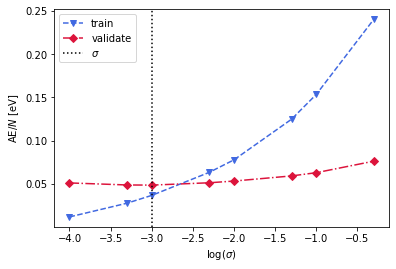

In [15]:
# Load surface
surface = np.loadtxt('./data_store/Results_validation_set/hypersurface_data.txt')
#plot surface 
plt.plot(np.log10(surface[:, 0]), surface[:, 1], 'v', ls='--', label='train',c='royalblue')
plt.plot(np.log10(surface[:, 0]), surface[:, 2], 'D', ls='-.', label='validate',c='crimson')
plt.axvline(np.log10(surface[np.argmin(surface[:, 2]), 0]), c='k', label=r'$\sigma$', ls=':')
plt.xlabel(r'log($\sigma$)')
plt.ylabel(r'AE/$N$ [eV]')
plt.legend()

print(f"Regularization parameter is: {surface[np.argmin(surface[:, 2]), 0]}")
print(f"{'sigma':7s} {'RMSE train [eV]':10s} {'RMSE validation [eV]':10s}")
for line in surface:
    print(f"{line[0]:0.5f} {line[1]:0.5f} {'':8s}{line[2]:0.5f}")

Kernel PCA:
-----------
In this script we show how to do a kernel PCA using the average kernel from above. Therefore the **kPCA()** function can be used which uses the kernel matrix as an input. The function returns the first three PCs with the three highest eigenvalues. These principal components can be ploted as it is shown below.

In [16]:
PC1, PC2, PC3 = kPCA(kernel_matrix)

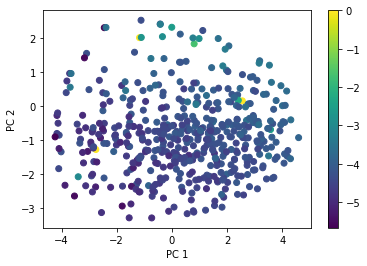

In [17]:
plt.scatter(PC1, PC2, c=AE_N)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar()

Or you can plot it in 3d

Text(0.5, 0, 'PC 3')

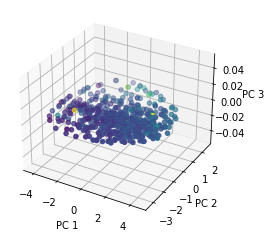

In [18]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(PC1, PC2, s=20, c=AE_N)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

In [19]:
# DOC
# README
# Depend. + description of data
# -jnotebook
# - functionen in module oder mltoolsconjugate

Reaction energies:
------------------
In this tutorial we use a very small reaction network of only three reactions as a showcase to illustrate how reaction energies can be calculated. The reaction network contains only dissociation and rearrangement reactions of type A -> B + C and A -> B. Note only those type of networks (e.g. like Rad-6-RE) can be analyzed via the underlying code. 

The first two steps should be familiar since we are now creating the similarity matrices for the 8 molecules to be predicted with the 500 molecules from the training set and predict the AE. 

In [27]:
# Load molecules included in the reaction network
m_RE = ase.io.read('./data_store/molecules/mols_reaction.xyz@:')
# Set molecules to the variable atoms_other and set lattices around them. 
gap.atoms_other = m_RE
gap.set_lattices(50, 'other')

# Calculate the two different descriptors for the multisoap kernel.
descs_RE_2 = gap.get_descriptors('other', desc_str_2)
kernel_RE_2 = gap.calc_soap_kernel_between_sets(
    descs_2,  # List with descriptors from the training set
    descs_RE_2,  # List with descriptors from the test set
    zeta=2.,
    kernel_type='average',
)
descs_RE_4 = gap.get_descriptors('other', desc_str_4)
kernel_RE_4 = gap.calc_soap_kernel_between_sets(
    descs_4,  # List with descriptors from the training set
    descs_RE_4,  # List with descriptors from the test set
    zeta=2.,
    kernel_type='average',
)
kernel_RE = 0.5*(kernel_RE_2 + kernel_RE_4)

In [28]:
# Prediction of AE/N for molecules in the network
y_RE = get_prediction(kernel_RE, alpha, mc=np.mean(AE_N))

# Grep N and AE from list with ase atoms objects
N_RE = np.asarray([float(len(mol.get_chemical_symbols())) for mol in m_RE]) 
AE_RE = np.asarray([mol.info['AE'] for mol in m_RE])

# Get MAE for AE
print(f"MAE RE set: {mean_absolute_error(AE_RE, y_RE*N_RE): .3f} eV")

MAE RE set:  0.374 eV


In the next step we detect how many molecules are involved in the network or rather what is the largest id of the molecules in the network. This is done because it is also possible that you have a database and not all molecules are part of the network. Therefore you need the id and not just the number of molecules. Usually both numbers are however the same. With this in hand we apply the function **read_reaction_network_g0()**. This functions returns the indices for the educts and products of the molecules (ids) that can be applied to the predicted AE arrays. We further use the function **append_energy_4_rearrangements()** to also account for rearrangement reactions by appending an entry with 0 eV to the predicted AE array.  

In [29]:
# Get molecule id's
ids = [mol.info['id'] for mol in m_RE]

# Append zero energy value atomization energies 
AE_RE_new = append_energy_4_rearrangements(y_RE*N_RE)
print(AE_RE_new)

# Get indices for molecules involved in the network
# Reaction network of type A -> B + C 
# e = indices of A, p1 = indices of B, p2 = indices of C 
e, p1, p2, reaction_energies = read_reaction_network_g0('./data_store/network/test_RE.txt', np.max(ids))



[-1.51597617e-02 -6.06698428e+01 -5.88562553e+01 -3.89428552e-02
 -4.04176510e+01 -3.41100901e+01 -6.61880242e+01 -6.57716030e+01
  0.00000000e+00]


The reaction energies can now be calculated by using the indices and substract the educts energies from the products.

In [30]:
RE_calc = (AE_RE_new[p1]+ AE_RE_new[p2])-AE_RE_new[e]
print(f"The obtained reaction energies are: {RE_calc}")
print(f"MAE for three reactions: {mean_absolute_error(reaction_energies, RE_calc):0.3f} eV")

The obtained reaction energies are: [1.79842775 6.26861805 0.41642118]
MAE for three reactions: 0.385 eV
